In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import statsmodels.api as sm

plt.style.use("bmh")

### Simple AR model test

In [3]:
arparams = np.array([.75, -.25])
ar = np.r_[1, -arparams]
maparams = np.array([0, 0])
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)

sm.tsa.ARIMA(endog=y, order=(2, 0, 0), trend="n").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -354.585
Date:                Sat, 14 Jan 2023   AIC                            715.170
Time:                        22:32:51   BIC                            725.734
Sample:                             0   HQIC                           719.422
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6777      0.057     11.819      0.000       0.565       0.790
ar.L2         -0.2976      0.065     -4.573      0.000      -0.425      -0.170
sigma2         0.9968      0.107      9.311      0.000       0.787       1.207
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.79   Prob(JB):                         0.16
Heteroskedasticity (H):               0.89   Skew:                            -0.11
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Simulate from multiple stationary AR models

In [4]:
alpha = 0.05
i = 0
summary = {}
while i < 10000:

    arparams = np.array([np.random.uniform(low=-1, high=1, size=1)[0], np.random.uniform(low=-1, high=1, size=1)[0]])
    ar = np.r_[1, -arparams]
    maparams = np.array([0, 0])
    ma = np.r_[1, maparams]
    y = sm.tsa.arma_generate_sample(ar, ma, 100)

    if sm.tsa.stattools.adfuller(y)[1] <= alpha:
        summary[i] = {"y": y, "coefs": arparams}
        i += 1

### Compute statistics from simulated data to be used on the prediction taks

In [20]:
j = 0
k = 0
m = 0

betadgp_beta2x2 = []
cov2x2 = []
corr2x2 = []
for i in range(len(summary.keys())):
    data = pd.DataFrame(summary[i]["y"], columns=["y"])

    for l in range(1, len(summary[i]["coefs"]) + 1):
        data.loc[:, "y_lag{}".format(str(l))] = data["y"].shift(l) 

    data = data.dropna()

    # beta 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        ols_fit = sm.OLS(endog=data["y"], exog=data["y_lag{}".format(str(l))]).fit()
        betadgp_beta2x2.append(pd.DataFrame({j: {"y": summary[i]["coefs"][l-1], "x": ols_fit.params[0]}}).T)
        j += 1

    # covariance 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        cov2x2.append(pd.DataFrame({k: {"y": summary[i]["coefs"][l-1], "x": data.cov().iloc[0][l]}}).T)
        k += 1

    # correlation 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        corr2x2.append(pd.DataFrame({k: {"y": summary[i]["coefs"][l-1], "x": data.corr().iloc[0][l]}}).T)
        m += 1

betadgp_beta2x2_df = pd.concat(betadgp_beta2x2, axis=0)
cov2x2_df = pd.concat(cov2x2, axis=0)

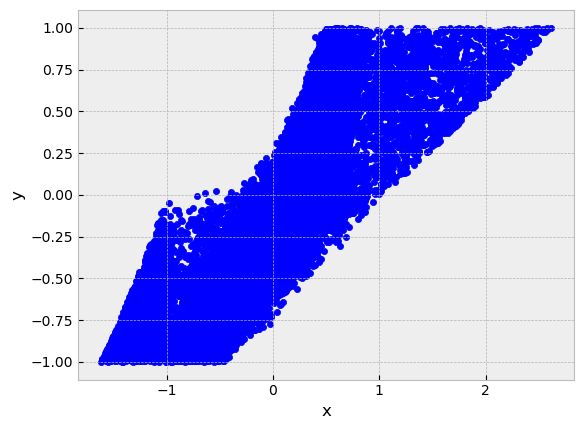

In [ ]:
betadgp_beta2x2_df.reset_index(drop=True).plot.scatter(y="y", x="x")

In [ ]:
cov2x2_df.reset_index(drop=True).plot.scatter(y="y", x="x")

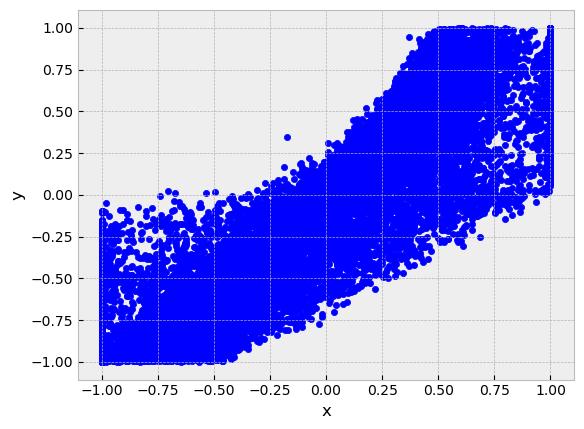

In [17]:
corr2x2_df.reset_index(drop=True).plot.scatter(y="y", x="x")

In [15]:
data.corr()

,y,y_lag1,y_lag2
y,1.000000,-0.336414,0.391240
y_lag1,-0.336414,1.000000,-0.338525
y_lag2,0.391240,-0.338525,1.000000
